In [200]:
# mapping = {'01':'Jan', '02':'Feb', '03':'Mar', '04':'Apr', '05':'May', '06':'Jun', '07':'Jul', '08':'Aug', '09':'Sep', '10':'Oct', '11':'Nov', '12':'Dec' }
# dates = pd.read_csv('C:/Users/rusrom.EUROPE/Downloads/dates2parse.csv', parse_dates = ['week_dt', 'month'])
# import datetime
# [datetime.date.strftime(dates['week_dt'][x], format = '%Y week %W') +' /'+ mapping[dates['month'][x][4:]] for x in dates.index]

In [1]:
# импортируем библиотеки
import numpy as np 
import pandas as pd 
from itertools import product
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
# загружаем данные
data_path = './'
train = pd.read_csv(data_path+'/train.csv', sep=';')
test = pd.read_csv(data_path+'/test.csv', sep=';')
test_y = pd.read_csv(data_path+'/test_answer.csv', sep=';')

In [4]:
train.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN


In [5]:
test.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,23.05.2016,1.0,NaN,128.98,119.6
1,1,1,24.05.2016,NaN,NaN,128.98,NaN
2,1,1,25.05.2016,NaN,NaN,131.70,NaN
3,1,1,26.05.2016,NaN,NaN,131.70,NaN
4,1,1,27.05.2016,NaN,NaN,131.70,NaN


In [6]:
test_y.head()

,Store_id,SKU_id,Date,Demand
0,1,1,23.05.2016,242
1,1,1,24.05.2016,57
2,1,1,25.05.2016,63
3,1,1,26.05.2016,69
4,1,1,27.05.2016,44


In [3]:
# Дату в формат даты. В колонке Price актуальная цена.
train.Date = pd.to_datetime(train.Date, format='%d.%m.%Y')
train['Price'] = np.log(train.Regular_Price)
train.loc[train['Promo'] == 1.0,'Price'] = np.log(train.loc[train['Promo'] == 1.0,'Promo_Price']) 
# суммируем спрос по магазинам
RegionSales = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Price':'mean'}).reset_index()

In [5]:
train.sample()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,Price
13863,28,1,2015-05-28,NaN,145,129.25,NaN,4.861749


In [9]:
RegionSales = train.groupby(['SKU_id','Date'])[['Price', 'Demand']].sum().reset_index()

In [10]:
RegionSales1 = RegionSales[RegionSales['SKU_id'] == 1]
RegionSales2 = RegionSales[RegionSales['SKU_id'] == 2]

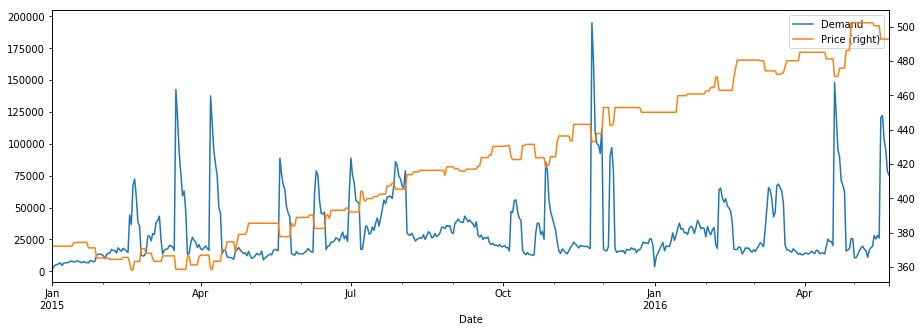

In [11]:
ax = RegionSales1.plot('Date', 'Demand', figsize=(15,5))
RegionSales1.plot('Date','Price', secondary_y=True, ax=ax)

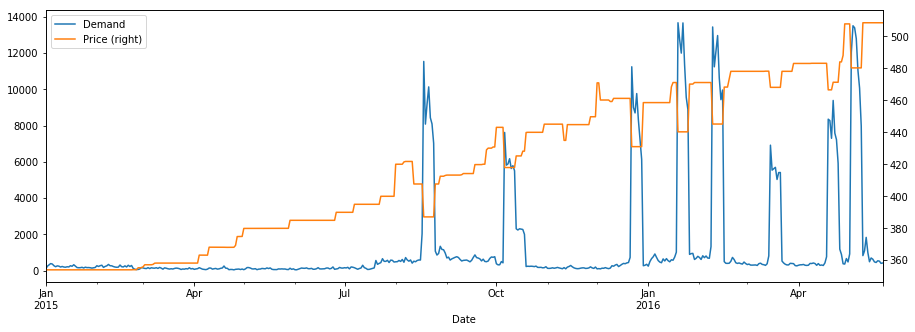

In [12]:
ax = RegionSales2.plot('Date', 'Demand', figsize=(15,5))
RegionSales2.plot('Date','Price', secondary_y=True, ax=ax)

In [12]:
# функция кросс-валидации по времени
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [36]:
# добавляем фичи
data = RegionSales.copy()

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,SKU_id,Date,Price,Demand,weekday,monthday,is_weekend
0,1,2015-01-01,372.235294,1180,3,1,0
1,1,2015-01-02,372.235294,3667,4,2,0
2,1,2015-01-03,372.235294,4987,5,3,1
3,1,2015-01-04,372.235294,5226,6,4,1
4,1,2015-01-05,372.235294,5951,0,5,0


In [37]:
# импортируем lightgbm
import lightgbm as lgb
lgbm = lgb.LGBMRegressor(
                        n_estimators=800,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

In [38]:
# дату превращаем в число
data.Date = data.Date.astype(np.int64)/1000000000/3600/24

In [39]:
# разбиваем по продукту
data1 = data[data['SKU_id'] == 1].copy()
data2 = data[data['SKU_id'] == 2].copy()

In [122]:
train1[(train1.SKU_id ==1) & (train1.Store_id ==106)].Demand.shift(-1)

Date
2016-03-29     44.0
2016-03-30     57.0
2016-03-31     41.0
2016-04-01     66.0
2016-04-02     53.0
2016-04-03     44.0
2016-04-04     41.0
2016-04-05     41.0
2016-04-06     38.0
2016-04-07     53.0
2016-04-08     35.0
2016-04-09     50.0
2016-04-10     31.0
2016-04-11     28.0
2016-04-12     31.0
2016-04-13     63.0
2016-04-14     41.0
2016-04-15     66.0
2016-04-16    101.0
2016-04-17     28.0
2016-04-18    393.0
2016-04-19    468.0
2016-04-20    569.0
2016-04-21    748.0
2016-04-22    578.0
2016-04-23    522.0
2016-04-24    289.0
2016-04-25     60.0
2016-04-26     72.0
2016-04-27     60.0
2016-04-28     97.0
2016-04-29     63.0
2016-04-30     28.0
2016-05-01     13.0
2016-05-02     47.0
2016-05-03     97.0
2016-05-04    101.0
2016-05-05     57.0
2016-05-06    104.0
2016-05-07     88.0
2016-05-08     44.0
2016-05-09    167.0
2016-05-10     69.0
2016-05-11     44.0
2016-05-12     85.0
2016-05-13    141.0
2016-05-14     66.0
2016-05-15     69.0
2016-05-16    697.0
2016-05-17    4

In [123]:
# train1.Demand.shift(-1)[(train1.SKU_id ==1) & (train1.Store_id ==106)] == train1[(train1.SKU_id ==1) & (train1.Store_id ==106)].Demand.shift(-1)
# train1.Demand.shift(-1)[(train1.SKU_id ==1) & (train1.Store_id ==106)]

In [54]:
a[a['Promo']==1]

Promo  Demand  Regular_Price  Promo_Price
SKU_id Store_id Date                                                 
1      1        17.02.2015    1.0     371         149.37       143.80
                18.02.2015    1.0     509         149.37       135.64
                19.02.2015    1.0     851         149.37       135.64
                20.02.2015    1.0     914         149.37       135.64
                21.02.2015    1.0     606         149.37       135.64
...                           ...     ...            ...          ...
                18.05.2016    1.0     814         128.98       119.60
                19.05.2016    1.0     672         128.98       119.60
                20.05.2016    1.0     603         128.98       119.60
                21.05.2016    1.0     311         128.98       119.60
                22.05.2016    1.0     393         128.98       119.60

[114 rows x 4 columns]

In [56]:
# a[(a.index.get_level_values('SKU_id') == 1) & ( a.index.get_level_values('Store_id') == 1)] 

In [108]:
train.reset_index(inplace = True)

In [163]:
# a = train
a = train[(train['SKU_id']==1) & (train['Store_id']==1)]
a['Deficit'] = 0
a.Promo.fillna(0, inplace=True)

aggregation_methods = {'mean', 'median', percentile(50), percentile(25)}
p = 1
d = 0


p_idx = d_idx = a.index 
if p <2:
    p_idx = a.Promo == p
if d <2:
    p_idx = a.Deficit == d 


a.loc[ ~ (p_idx & d_idx), 'Demand'] = np.NaN

a.set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)

ans = (a[['Demand']].groupby(level=['SKU_id', 'Store_id']).
    apply(lambda x: x.rolling(window=7, min_periods = 1).
          agg(aggregation_methods))
        )

# a[['Demand']].groupby(level=['SKU_id', 'Store_id', 'Date']).rolling(7, min_periods = 2).mean()

# min_periods=1
# a[['Demand']].groupby(level=['SKU_id', 'Store_id', 'Date']).apply(lambda x: pd.rolling_sum(x,2))

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a 

In [166]:
# a.reset_index(inplace=True)
# filter_mapping = {0:'n', 1:'o', 2:'a'}

# ans.columns = [x[1] for x in ans.columns.values]

# names = dict(ans.columns)
new_names = {x: "lag{0}_wdw{1}_{2}_{3}prm_{4}dfc".
                              format(14, 7, x, filter_mapping[1],filter_mapping[0]) for x in ans.columns }

# ans.rename(columns = new_names)
# ans.columns = ["lag{0}_wdw{1}_{2}_{3}prm_{4}dfc".
#                               format(7, 7, x, filter_mapping[1],filter_mapping[0]) for x in ans.columns.values]

#  {"lag{0}_wdw{1}_{2}_{3}prm_{4}dfc".format(7, 7, x[1], filter_mapping[1],filter_mapping[0]) for x in ans.columns.values}
# {'a', 'b', 'c', 'd'}
# ans.columns
# ans.rename(['a', 'b', 'c', 'd'])
a = a.merge(ans.shift(14).reset_index().rename(columns = new_names),
            how='left', on =['SKU_id', 'Store_id', 'Date'] )
              

In [228]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df 
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , promo_filters = [0, 1]
                    , deficit_filters = [0, 1]
                    , target_var = 'Demand'):

    
    filter_mapping = {0:'n', 1:'o', 2:'a'}
    
    
    for p, d in product(promo_filters, deficit_filters):
        for w in windows:
            
            # define dates for each SKU and Store pairs        
            p_idx = d_idx = df.index 
            if p <2:
                p_idx = df.Promo == p
            if d <2:
                p_idx = df.Deficit == d 

            if len(df[p_idx&d_idx].index)>0:
                lf_df = df[p_idx&d_idx].set_index(['SKU_id', 'Store_id', 'Date']).\
                     Demand.groupby(level=['SKU_id', 'Store_id']).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))

    #             # get rid of multi-index in
    #             lf_df.columns = [x[1] for x in lf_df.columns]

                for l in lags:

                    new_names = {x: "lag{0}_wdw{1}_{2}_{3}prm_{4}dfc".
                                  format(14, 7, x, filter_mapping[1],filter_mapping[0]) for x in lf_df.columns }


                    df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                        how='left', on =['SKU_id', 'Store_id', 'Date'] )
            
    return df

In [231]:
a = train
# a = train[(train['SKU_id']==1) & (train['Store_id']==1)]
a['Deficit'] = 0
a.Promo.fillna(0, inplace=True)

lf = lagged_features(a, promo_filters = [1] , deficit_filters = [0])

In [230]:
lf

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,Deficit,lag14_wdw7_pctl10_oprm_ndfc_x,lag14_wdw7_pctl90_oprm_ndfc_x,...,lag14_wdw7_mean_oprm_ndfc_y,lag14_wdw7_median_oprm_ndfc_y,lag14_wdw7_pctl10_oprm_ndfc_x,lag14_wdw7_pctl90_oprm_ndfc_x,lag14_wdw7_mean_oprm_ndfc_x,lag14_wdw7_median_oprm_ndfc_x,lag14_wdw7_pctl10_oprm_ndfc_y,lag14_wdw7_pctl90_oprm_ndfc_y,lag14_wdw7_mean_oprm_ndfc_y,lag14_wdw7_median_oprm_ndfc_y
0,1,1,01.01.2015,0.0,22,163.78,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,02.01.2015,0.0,41,163.78,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,03.01.2015,0.0,35,163.78,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,04.01.2015,0.0,72,163.78,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,05.01.2015,0.0,25,163.78,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,1,1,18.05.2016,1.0,814,128.98,119.6,0,68.0,528.8,...,240.071429,170.0,121.1,563.0,275.071429,218.5,97.0,563.0,259.857143,176.0
504,1,1,19.05.2016,1.0,672,128.98,119.6,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,1,1,20.05.2016,1.0,603,128.98,119.6,0,68.0,258.4,...,277.571429,170.0,106.4,563.0,257.142857,184.0,97.0,563.0,264.785714,206.0
506,1,1,21.05.2016,1.0,311,128.98,119.6,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# выделяем X и у
X_train = data1.drop(['SKU_id','Demand'], axis=1)
y_train = data1.Demand

In [20]:
# функция WAPE
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [21]:
# параметры lightgbm
kwargs = {'early_stopping_rounds':10,'verbose':2}

In [22]:
%%time
performTimeSeriesCV(X_train, y_train, 17, lgbm, wape, kwargs)
# запускаем lightgbm на трейн

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 10488.2
[4]	valid_0's l1: 10488.2
[6]	valid_0's l1: 10488.2
[8]	valid_0's l1: 10488.2
[10]	valid_0's l1: 10488.2
Early stopping, best iteration is:
[1]	valid_0's l1: 10488.2

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 22879
[4]	valid_0's l1: 21804.7
[6]	valid_0's l1: 20976.2
[8]	valid_0's l1: 20280.7
[10]	valid_0's l1: 19694.7
[12]	valid_0's l1: 19300.4
[14]	valid_0's l1: 19162
[16]	valid_0's l1: 18913.2
[18]	valid_0's l1: 18901.2
[20]	valid_0's l1: 18624
[22]	valid_0's l1: 18483.8
[24]	valid_0's l1: 18345.3
[26]	valid_0's l1: 18260.1
[28]	valid_0's l1: 18081.1
[30]	valid_0's l1: 18013.3
[32]	valid_0's l1: 18041.3
[34]	valid_0's l1: 18058.6
[36]	valid_0's l1: 17912.6
[38]	valid_0's l1: 17926.8


Splitting the first 14 chunks at 13/14
Size of train + test: (406, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 5134.71
[4]	valid_0's l1: 4803.34
[6]	valid_0's l1: 4436.27
[8]	valid_0's l1: 4716.1
[10]	valid_0's l1: 5401.64
[12]	valid_0's l1: 5212.29
[14]	valid_0's l1: 5115.73
[16]	valid_0's l1: 5357.85
Early stopping, best iteration is:
[7]	valid_0's l1: 4434.27

Splitting the first 15 chunks at 14/15
Size of train + test: (435, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 12270.3
[4]	valid_0's l1: 9792.85
[6]	valid_0's l1: 8440.72
[8]	valid_0's l1: 7785.63
[10]	valid_0's l1: 7296.22
[12]	valid_0's l1: 6369.49
[14]	valid_0's l1: 6112.87
[16]	valid_0's l1: 6206.09
[18]	valid_0's l1: 5741.02
[20]	valid_0's l1: 5939.94
[22]	valid_0's l1: 6070.35
[24]	valid_0's l1: 5884.3
[26]	valid_0's l1: 5738.62
[28]	valid_0's l1: 5639.85
[30]	valid_0's l1: 5609.61
[32]	valid_0's l1: 5537.17
[34]	valid_0's l1: 5520.53
[36]	val

27.5281930470058

In [44]:
# объединяем трейн и тест
test.Date = pd.to_datetime(test.Date, format='%d.%m.%Y')
df = pd.concat([train, test], axis=0, sort=False, ignore_index=True)

In [45]:
df.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price,Price
0,1,1,2015-01-01,NaN,22.0,163.78,NaN,5.098524
1,1,1,2015-01-02,NaN,41.0,163.78,NaN,5.098524
2,1,1,2015-01-03,NaN,35.0,163.78,NaN,5.098524
3,1,1,2015-01-04,NaN,72.0,163.78,NaN,5.098524
4,1,1,2015-01-05,NaN,25.0,163.78,NaN,5.098524


In [48]:
# add test-flag
df['test'] = 0
df.loc[df.Demand.isnull(), 'test'] = 1

In [51]:
# предобработка как в предыдущий раз
df.Date = pd.to_datetime(df.Date, format='%d.%m.%Y')
df['Price'] = np.log(df.Regular_Price)
df.loc[df['Promo'] == 1.0,'Price'] = np.log(df.loc[df['Promo'] == 1.0,'Promo_Price']) 
data = df.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Price':'mean','test':'first'}).reset_index()

In [52]:
data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,SKU_id,Date,Demand,Promo,Store_id,Price,test,weekday,monthday,is_weekend
0,1,2015-01-01,1180.0,0.0,73,5.099114,0,3,1,0
1,1,2015-01-02,3667.0,0.0,73,5.099114,0,4,2,0
2,1,2015-01-03,4987.0,0.0,73,5.099114,0,5,3,1
3,1,2015-01-04,5226.0,0.0,73,5.099114,0,6,4,1
4,1,2015-01-05,5951.0,0.0,73,5.099114,0,0,5,0


In [53]:
data.Date = data.Date.astype(np.int64)/1000000000/3600/24

In [54]:
# разбиваем на два продукта
data1 = data[data['SKU_id'] == 1].copy()
data2 = data[data['SKU_id'] == 2].copy()

In [55]:
# лаги
n_lag = 14
for i in range(1, n_lag):
    data1["lag_{}".format(i)] = data1.Demand.shift(i)
    data2["lag_{}".format(i)] = data2.Demand.shift(i)

In [56]:
data1.head()

,SKU_id,Date,Demand,Promo,Store_id,Price,test,weekday,monthday,is_weekend,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
0,1,16436.0,1180.0,0.0,73,5.099114,0,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,16437.0,3667.0,0.0,73,5.099114,0,4,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,16438.0,4987.0,0.0,73,5.099114,0,5,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,16439.0,5226.0,0.0,73,5.099114,0,6,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,16440.0,5951.0,0.0,73,5.099114,0,0,5,0,...,1180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Х и у для трениировки
X_train1 = data1[data1['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train1 = data1[data1['test'] == 0].Demand
X_train2 = data2[data2['test'] == 0].drop(['SKU_id','Store_id','Demand','test'], axis=1)
y_train2 = data2[data2['test'] == 0].Demand

In [58]:
# тесты по продуктам
X_test1 = data1[data1['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)
X_test2 = data2[data2['test'] == 1].drop(['SKU_id','Store_id','Demand','test'], axis=1)

In [59]:
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm, wape, kwargs)
# тренируем lightgbm на продукте 1

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 10488.2
[4]	valid_0's l1: 10488.2
[6]	valid_0's l1: 10488.2
[8]	valid_0's l1: 10488.2
[10]	valid_0's l1: 10488.2
Early stopping, best iteration is:
[1]	valid_0's l1: 10488.2

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 22879
[4]	valid_0's l1: 21847.3
[6]	valid_0's l1: 21158.7
[8]	valid_0's l1: 20866.5
[10]	valid_0's l1: 20610.2
[12]	valid_0's l1: 20363
[14]	valid_0's l1: 20259.5
[16]	valid_0's l1: 20248.4
[18]	valid_0's l1: 20247.3
[20]	valid_0's l1: 20179.2
[22]	valid_0's l1: 20135
[24]	valid_0's l1: 20103.7
[26]	valid_0's l1: 20009.7
[28]	valid_0's l1: 19980.4
[30]	valid_0's l1: 19967.5
[32]	valid_0's l1: 19951.3
[34]	valid_0's l1: 19983.3
[36]	valid_0's l1: 19972.5
[38]	valid_0's l1: 19958.6

29.601700206347253

In [60]:
# лаги по предиктам на трейне расписываем  
for d in range(len(X_test1)):
    y_pred = lgbm.predict(X_test1)
    for i in range(1, n_lag):
        lag_i = pd.Series(y_pred).shift(i)
        X_test1.loc[lag_i.notnull().values,"lag_{}".format(i)] = lag_i[lag_i.notnull()].values

In [61]:
X_test1

,Date,Promo,Price,weekday,monthday,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
508,16944.0,103.0,4.784153,0,23,0,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000,25386.000000,28096.000000,19632.000000,18511.000000,16585.000000
509,16945.0,0.0,4.859657,1,24,0,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000,25386.000000,28096.000000,19632.000000,18511.000000
510,16946.0,0.0,4.880527,2,25,0,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000,25386.000000,28096.000000,19632.000000
511,16947.0,0.0,4.880527,3,26,0,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000,25386.000000,28096.000000
512,16948.0,0.0,4.880527,4,27,0,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000,25386.000000
513,16949.0,0.0,4.880527,5,28,1,21832.219943,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000,28182.000000
514,16950.0,0.0,4.880527,6,29,1,21550.636744,21832.219943,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000,26185.000000
515,16951.0,0.0,4.880527,0,30,0,21840.703923,21550.636744,21832.219943,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000,120749.000000
516,16952.0,0.0,4.880527,1,31,0,19977.599448,21840.703923,21550.636744,21832.219943,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000,122195.000000
517,16953.0,0.0,4.872420,2,1,0,20466.590497,19977.599448,21840.703923,21550.636744,21832.219943,22726.420054,27045.158096,38404.053448,77284.201900,75491.000000,78316.000000,95310.000000,103539.000000


In [62]:
# предсказываем по продукту 1
y_pred1 = lgbm.predict(X_test1)

In [63]:
# тренируем lightgbm на трейне по продукту 2
performTimeSeriesCV(X_train2, y_train2, 17, lgbm, wape, kwargs)

Size train set: (508, 19)
Size of each fold: 29

Splitting the first 2 chunks at 1/2
Size of train + test: (58, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 224.948
[4]	valid_0's l1: 224.948
[6]	valid_0's l1: 224.948
[8]	valid_0's l1: 224.948
[10]	valid_0's l1: 224.948
Early stopping, best iteration is:
[1]	valid_0's l1: 224.948

Splitting the first 3 chunks at 2/3
Size of train + test: (87, 19)
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 89.808
[4]	valid_0's l1: 85.0218
[6]	valid_0's l1: 83.627
[8]	valid_0's l1: 79.9298
[10]	valid_0's l1: 77.1689
[12]	valid_0's l1: 75.9858
[14]	valid_0's l1: 76.0663
[16]	valid_0's l1: 73.8404
[18]	valid_0's l1: 71.8563
[20]	valid_0's l1: 73.6429
[22]	valid_0's l1: 71.4585
[24]	valid_0's l1: 71.1077
[26]	valid_0's l1: 71.1359
[28]	valid_0's l1: 72.9421
[30]	valid_0's l1: 70.1804
[32]	valid_0's l1: 71.8533
[34]	valid_0's l1: 71.7691
[36]	valid_0's l1: 72.5814
[38]	valid_0's l1: 71.

Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 3328.19
[4]	valid_0's l1: 2966.89
[6]	valid_0's l1: 2747.53
[8]	valid_0's l1: 2585.17
[10]	valid_0's l1: 2368.92
[12]	valid_0's l1: 2192.82
[14]	valid_0's l1: 2095.36
[16]	valid_0's l1: 1973.51
[18]	valid_0's l1: 1875.75
[20]	valid_0's l1: 1833.29
[22]	valid_0's l1: 1770
[24]	valid_0's l1: 1721.73
[26]	valid_0's l1: 1679.65
[28]	valid_0's l1: 1650.79
[30]	valid_0's l1: 1622.49
[32]	valid_0's l1: 1602.05
[34]	valid_0's l1: 1573.59
[36]	valid_0's l1: 1541.49
[38]	valid_0's l1: 1522.51
[40]	valid_0's l1: 1519.06
[42]	valid_0's l1: 1504.72
[44]	valid_0's l1: 1484.18
[46]	valid_0's l1: 1483.1
[48]	valid_0's l1: 1479.8
[50]	valid_0's l1: 1479.08
[52]	valid_0's l1: 1469.59
[54]	valid_0's l1: 1468.35
[56]	valid_0's l1: 1453.38
[58]	valid_0's l1: 1450.41
[60]	valid_0's l1: 1447.39
[62]	valid_0's l1: 1445.6
[64]	valid_0's l1: 1434.46
[66]	valid_0's l1: 1428.49
[68]	valid_0's l1: 1430.46
[70]	valid_0's l1: 1440.66
[72]

46.93496511976799

In [64]:
# расписываем лаги
for d in range(len(X_test2)):
    y_pred = lgbm.predict(X_test2)
    for i in range(1, n_lag):
        lag_i = pd.Series(y_pred).shift(i)
        X_test2.loc[lag_i.notnull().values,"lag_{}".format(i)] = lag_i[lag_i.notnull()].values

In [65]:
# предсказываем продукт2
y_pred2 = lgbm.predict(X_test2)

In [66]:
y_pred1


array([77284.20190044, 38404.05344752, 27045.15809644, 22726.42005432,
       21832.21994335, 21550.63674373, 21840.7039226 , 19977.59944842,
       20466.59049732, 18947.80879054, 18746.46859379, 18522.98869434,
       17901.75314939, 17171.41511274, 16440.55806059, 23396.50896683,
       25688.51427728, 27745.37937187, 27806.88106339, 28238.00598737,
       26784.96342756, 25864.8030828 , 50498.54757724, 59709.90632222,
       66170.71446455, 69686.84363203, 71524.36059571, 71757.09986323])

In [67]:
test_y.head()

,Store_id,SKU_id,Date,Demand
0,1,1,23.05.2016,242
1,1,1,24.05.2016,57
2,1,1,25.05.2016,63
3,1,1,26.05.2016,69
4,1,1,27.05.2016,44


In [68]:
# берем y_true
test_y.Date = pd.to_datetime(test_y.Date, format='%d.%m.%Y')
df_test_y = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index()

In [69]:
y_true1 = df_test_y.loc[df_test_y['SKU_id'] == 1].Demand.values
y_true2 = df_test_y.loc[df_test_y['SKU_id'] == 2].Demand.values
y_true1

array([63525, 19965, 16153, 14859, 17016, 14554, 15598, 15059, 16788,
       16818, 18951, 24469, 24433, 28979, 21584, 23395, 22686, 20673,
       25408, 19320, 17545, 17273, 45657, 45790, 69028, 78149, 68752,
       66319], dtype=int64)

In [70]:
# считаем WAPE по продукту 1
wape(y_pred1, y_true1)

22.01949955260766

In [71]:
# считаем WAPE по продукту 2
wape(y_pred2, y_true2)

20.647486036374872